In [1]:
import pandas as pd
from pandas import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pyramid
from pyramid.arima import auto_arima,ARIMA

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

Using TensorFlow backend.


## Data preprocessing

* The data is first cleaned form missing values where the previous value is simply filled in. 
* The y label is then constructed as the 5th observation of the opening price after the series of X variables. The 5th since the model will be evaluated on the performance of forecasting 5 steps (days) ahead in time ('preds_steps'). 
* The length of the input series is set to 180 steps ('len_input') and the number of observations left out to be used as a test set is 100 ('no_preds_in_test'). 
* The time-series are scaled with a min-max scaler.

In [4]:
preds_steps = 5
len_input = 180
no_preds_in_test = 100

The dataset consists of 1259 observations ranging from 2013-08-26 to 2018-08-24. All X-variables; Open, High, Low, Close and  Volume (Adj Close is excluded since it correlates too strongly with Close) are used predict the Opening price so the model can see variations within each day.

In [5]:
data = pd.read_csv('/Users/andreashaggstrom/Downloads/Data Science/OMXseries.csv')

In [40]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-08-26,1245.599976,1246.949951,1234.910034,1245.989990,1245.989990,54061600.0
1,2013-08-27,1240.890015,1241.410034,1222.439941,1224.849976,1224.849976,90128700.0
2,2013-08-28,1208.010010,1226.020020,1206.119995,1218.150024,1218.150024,88445100.0
3,2013-08-29,1222.790039,1225.530029,1218.420044,1224.310059,1224.310059,67169400.0
4,2013-08-30,1226.170044,1226.229980,1214.020020,1214.349976,1214.349976,80503700.0


In [7]:
data = data.fillna(method='ffill')

In [8]:
y_labels = []
for x in range(0,len(data)-len_input-preds_steps + 1):
    y_labels.append(data['Open'][x + len_input + preds_steps - 1])

In [9]:
y_train = y_labels[:-no_preds_in_test]
y_train = np.array(y_train)
y_train = y_train.reshape(-1, 1)

In [10]:
sc_y = MinMaxScaler(feature_range = (0, 1))
y_train = sc_y.fit_transform(y_train)

In [11]:
y_test = y_labels[-(no_preds_in_test-preds_steps):]
y_test = np.array(y_test)
y_test = y_test.reshape(-1, 1)
y_test = sc_y.transform(y_test)

In [12]:
training_set = data.iloc[0:len(data)-no_preds_in_test+1,[1,2,3,4,6]].values

In [13]:
test_set = data.iloc[len(data)-(no_preds_in_test+len_input):,[1,2,3,4,6]].values

In [14]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [15]:
X_train = []
for i in range(len_input, len(training_set)-preds_steps):
    X_train.append(training_set_scaled[i-len_input:i, :])
X_train = np.array(X_train)

In [16]:
test_set_scaled = sc.transform(test_set)

In [17]:
X_test = []
for i in range(len_input, len(test_set)-preds_steps):
    X_test.append(test_set_scaled[i-len_input+1:i+1, :])
X_test = np.array(X_test)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [19]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

## Model

* The model is a recurrent neural network (RNN) with 64 LSTM units and one fully connected output layer with a linear activation.
* The loss is measured with mean squared error.
* The Adam optimizer is used with a learning rate of 0.001.
* The model is trained for 30 epochs.

In [20]:
model = Sequential()

In [21]:
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))

In [22]:
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
975/975 [==============================] - 122s 126ms/step - loss: 0.0101 - mean_absolute_error: 0.0697
Epoch 2/30
975/975 [==============================] - 117s 120ms/step - loss: 0.0057 - mean_absolute_error: 0.0580
Epoch 3/30
975/975 [==============================] - 117s 120ms/step - loss: 0.0054 - mean_absolute_error: 0.0562
Epoch 4/30
975/975 [==============================] - 117s 120ms/step - loss: 0.0049 - mean_absolute_error: 0.0535
Epoch 5/30
975/975 [==============================] - 118s 122ms/step - loss: 0.0047 - mean_absolute_error: 0.0519
Epoch 6/30
975/975 [==============================] - 119s 122ms/step - loss: 0.0046 - mean_absolute_error: 0.0523
Epoch 7/30
975/975 [==============================] - 130s 133ms/step - loss: 0.0046 - mean_absolute_error: 0.0528
Epoch 8/30
975/975 [==============================] - 123s 127ms/step - loss: 0.0045 - mean_absolute_error: 0.0521
Epoch 9/30
975/975 [==============================] - 121s 125ms/step - loss: 0.

The loss is decreasing towards 0.0039 with diminishing returns after the 30th epoch. 

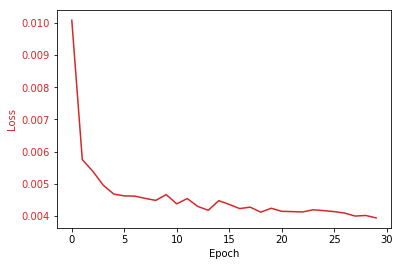

In [26]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

## Forecast and evaluation

100 time-steps are left for prediction and evaluation 5 time-steps ahead in time. 

In [27]:
predicted_stock_price = model.predict(X_test,batch_size=1)

In [29]:
predicted_stock_price = sc_y.inverse_transform(predicted_stock_price)

In [30]:
real_values = np.array(data['Open'][-(no_preds_in_test-preds_steps):]).reshape(-1,1)

An ARIMA model is built as a benchmark using auto_arima.

In [58]:
arima_predictions = []
for i in range(0,(no_preds_in_test-preds_steps)):
    arima = auto_arima(data['Open'][:-(no_preds_in_test-i)],suppress_warnings=True,error_action="ignore")
    preds = arima.predict(preds_steps)
    arima_predictions.append(preds[preds_steps-1])

In [59]:
rnn_rmse = np.sqrt(mean_squared_error(real_values,predicted_stock_price))
print('RNN RMSE:',round(rnn_rmse))

RNN RMSE: 22.0


In [60]:
arima_rmse = np.sqrt(mean_squared_error(real_values,arima_predictions))
print('ARIMA RMSE:',round(arima_rmse))

ARIMA RMSE: 26.0


The RNN yields a lower root mean squared error and according to the below plot seem to react quicker to price changes than the ARIMA.

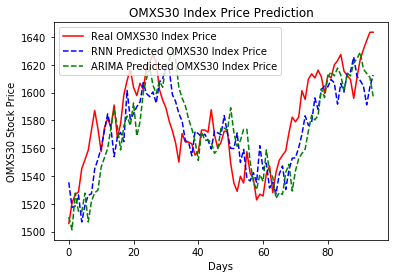

In [64]:
plt.plot(real_values, color = 'red', label = 'Real OMXS30 Index Price')
plt.plot(predicted_stock_price, color = 'blue',linestyle='dashed', label = 'RNN Predicted OMXS30 Index Price')
plt.plot(arima_predictions, color = 'green',linestyle='dashed', label = 'ARIMA Predicted OMXS30 Index Price')
plt.title('OMXS30 Index Price Prediction')
plt.xlabel('Days')
plt.ylabel('OMXS30 Stock Price')
plt.legend()